# 3c. Predict bed demand by hospital service

Hospitals organise their inpatient beds by hospital service — for example, medical, surgical, paediatric, or haematology/oncology beds. When predicting emergency demand for beds, it is useful to disaggregate overall demand into predictions for each hospital service, so that bed managers can plan for pressures in specific areas. In the data used here, the hospital service is recorded as the `specialty` a patient is admitted under.

In this notebook I show how `patientflow` can be used to predict demand by hospital service. I also show an example of stratifying predictions by an observed patient characteristic (sex). In both cases, I focus on predictions from patients currently in the ED. Later notebooks will consider patients yet-to-arrive, who may need admission with a prediction window.

### Predicting which hospital service a patient will need

When patients are still in the ED, we don't yet know which hospital service they will be admitted to.

I demonstrate the use of a `SequenceToOutcomePredictor` class, which predicts each patient's probability of admission to each hospital service, based on sequences of consult requests made while patients are in the ED.

The `SequenceToOutcomePredictor` approach could be used with other sequence data, such as sequences of locations or procedures, if you deem these likely to be associated with a patient being admitted to a particular hospital service. The key assumption of the sequence design is that the order is meaningful; for example, a surgical consult following a medical consult, or vice versa, is meaningful for the patient's likelihood of being admitted under surgery. 

If you don't have sequences for predicting hospital service, you might have simpler data, such as a single reason code for each visit, entered on triage (eg heart problem, broken bone), that suggests which service a patient will end up in. I demonstrate a `ValueToOutcomePredictor` which can be used with such data. 

### Combining specialty prediction with admission prediction

I then combine the specialty prediction model with the admission probability model (shown in previous notebooks) to calculate the joint probability that a patient will both be admitted and require a specific specialty. Formally, this derives P(admitted AND specialty X) = P(admitted) × P(specialty X | admitted). This joint probability approach means we can generate specialty-specific bed count predictions. I demonstrate the joint probability for one group snapshot. 

I deliberately excluded consult types from the admissions model to ensure the two models use independent signals, avoiding potential overfitting when combining their predictions.

### Stratifying by observed characteristics

Finally, I show a different type of subgroup analysis by stratifying patients by sex. Since sex is directly observed rather than predicted, I create separate bed count distributions for male and female patients.

## Load real patient data

Following the approach taken in the previous notebook, I'll first load some real patient data. 

In [23]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import pandas as pd
from patientflow.load import set_file_paths, load_data, load_config_file

# set project root
from patientflow.load import set_project_root
project_root = set_project_root()

# set file paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        project_root, 
        data_folder_name='data-public', # change this to data-synthetic if you don't have the public dataset
        verbose=False) 

# load the data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date

# load the config file to set the dates for the training, validation and test sets
params = load_config_file(config_path)
start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]

# apply the temporal splits
from patientflow.prepare import create_temporal_splits

# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date to use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 

)


Inferred project root: /Users/zellaking/Repos/patientflow
Split sizes: [62071, 10415, 29134]


## Train a model to predict probability of admission to each specialty

### Predict specialty of admission using sequences of consults

In this example, the data used as input comprise sequences of consults issued while the patient was in the ED. The `consultation_sequence` column shows the ordered sequence of consultation requests up to the moment of the snapshot, and the `final_sequence` shows the ordered sequence at the end of the ED visit. The `specialty` column records which specialty the patient was admitted to.  

In [25]:
ed_visits[(ed_visits.is_admitted) & (ed_visits.prediction_time == (9,30))][['consultation_sequence', 'final_sequence', 'specialty']].head(10)


,consultation_sequence,final_sequence,specialty
snapshot_id,,,
183349,"['acute', 'discharge']","['acute', 'discharge']",medical
132235,['paeds'],['paeds'],paediatric
114978,[],['acute'],medical
199212,[],[],paediatric
202378,[],['surgical'],medical
200273,[],['acute'],medical
171735,[],[],NaN
140899,['haem_onc'],['haem_onc'],haem/onc
122882,['acute'],"['acute', 'medical', 'elderly']",medical


Below I demonstrate training the model. A rooted decision-tree is used to calculate:

* the probability of an ordered sequence of consultations observed at the snapshot (which could be none) resulting in each final sequence at the end of the ED visit
* the probability of each of those final sequences being associated with admission to each specialty (the outcome)

This sequence predictor could be applied to other types of data, such as sequences of ED locations, or sequences of clinical teams visited. Therefore, the `SequenceToOutcomePredictor` arguments have been given generic names: 

* `input_var` - the interim node in the decision tree, observed at the snapshot
* `grouping_var` - the terminal node in the decision tree, observed in this example at the end of the ED visit
* `outcome_var` - the final outcome to be predicted

The `apply_special_category_filtering` argument provides for the handling of certain categories in a specific way. For example, under 18 patients might always be assumed to be visiting paediatric specialties. I demonstrate this in a later notebook.


In [26]:
from patientflow.predictors.sequence_to_outcome_predictor import SequenceToOutcomePredictor

spec_model = SequenceToOutcomePredictor(
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    apply_special_category_filtering=False,
)

spec_model.fit(train_visits)

SequenceToOutcomePredictor(
    input_var='consultation_sequence',
    grouping_var='final_sequence',
    outcome_var='specialty',
    apply_special_category_filtering=False,
    admit_col='is_admitted'
)

From the weights that are returned, we can view the probability of being admitted to each specialty for a patient who has no consultation sequence at the time of prediction

In [27]:
print(
    f'Probability of being admitted to each specialty at the end of the visit if no consultation result has been made by the time of the snapshot:\n'
    f'{dict((k, round(v, 3)) for k, v in spec_model.weights[()].items())}'
)

Probability of being admitted to each specialty at the end of the visit if no consultation result has been made by the time of the snapshot:
{'medical': 0.611, 'surgical': 0.248, 'paediatric': 0.061, 'haem/onc': 0.08}


Similar we can view the probability of being admitted to each specialty after a consultation request to acute medicine

In [28]:
print(
    f'\nProbability of being admitted to each specialty if one consultation request to acute medicine has taken place by the time of the snapshot:\n'
    f'{dict((k, round(v, 3)) for k, v in spec_model.weights[("acute",)].items())}'
)


Probability of being admitted to each specialty if one consultation request to acute medicine has taken place by the time of the snapshot:
{'medical': 0.95, 'surgical': 0.017, 'paediatric': 0.002, 'haem/onc': 0.032}


The intermediate mapping of consultation_sequence to final_sequence can be accessed from the trained model like this. The first row shows the probability of a null sequence (ie no consults yet) ending in any of the final_sequence options. 

In [29]:
spec_model.input_to_grouping_probs.iloc[:, :10]

final_sequence,(),"(acute,)","(acute, acute)","(acute, acute, acute)","(acute, acute, discharge)","(acute, acute, icu)","(acute, acute, medical)","(acute, acute, medical, surgical)","(acute, acute, mental_health)","(acute, acute, palliative)"
consultation_sequence,,,,,,,,,,
(),0.015452,0.433579,0.014760,0.000231,0.000231,0.000,0.000692,0.000231,0.000461,0.000
"(acute,)",0.000000,0.820442,0.007182,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000
"(acute, acute)",0.000000,0.000000,0.850000,0.000000,0.025000,0.025,0.075000,0.000000,0.000000,0.025
"(acute, acute, medical)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000,1.000000,0.000000,0.000000,0.000
"(acute, allied)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...
"(surgical, paeds)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000
"(surgical, surgical)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000
"(surgical, surgical, acute)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000


#### Using the `SequenceToOutcomePredictor` 

Below I apply the predict function to get each patient's probability of being admitted to the four specialties.

In [30]:
test_visits['consultation_sequence'].head().apply(spec_model.predict)

snapshot_id
192732    {'medical': 0.1318359375, 'surgical': 0.826171...
209659    {'medical': 0.09243697478991597, 'surgical': 0...
207377    {'medical': 0.8333333333333333, 'surgical': 0....
216864    {'medical': 0.6107109665427509, 'surgical': 0....
207071    {'medical': 0.6107109665427509, 'surgical': 0....
Name: consultation_sequence, dtype: object

A dictionary is returned for each patient, with probabilites summed to 1. To get each patient's probability of admission to one specialty indexed in the dictionary, we can select that key as shown below:

In [31]:
print("Probability of admission to medical specialty for the first five patients:")
test_visits['consultation_sequence'].head().apply(spec_model.predict).apply(lambda x: x['medical']).values


Probability of admission to medical specialty for the first five patients:


array([0.13183594, 0.09243697, 0.83333333, 0.61071097, 0.61071097])

### Predicting specialty of admission using a simpler input

If your data for predicting specialty has a simpler structure, say in the form of a string variable containing reasons for presentation at ED, `patientflow` offers a simpler model. 

To illustrate this, I create a temporary column by truncating the sequence data to the first item in the list only.  

In [32]:
ed_visits['temp_consultation_sequence'] = ed_visits['consultation_sequence'].apply(
    lambda x: x[0].strip("'") if isinstance(x, (list, tuple)) and len(x) > 0 else None
)

ed_visits['temp_final_sequence'] = ed_visits['final_sequence'].apply(
    lambda x: x[0].strip("'") if isinstance(x, (list, tuple)) and len(x) > 0 else None
)

ed_visits[(ed_visits.is_admitted) & (ed_visits.prediction_time == (9,30))][['temp_consultation_sequence', 'temp_final_sequence', 'specialty']].head(10)


,temp_consultation_sequence,temp_final_sequence,specialty
snapshot_id,,,
183349,acute,acute,medical
132235,paeds,paeds,paediatric
114978,None,acute,medical
199212,None,None,paediatric
202378,None,surgical,medical
200273,None,acute,medical
171735,None,None,NaN
140899,haem_onc,haem_onc,haem/onc
122882,acute,acute,medical


In [33]:
# create the temporal splits
train_visits, valid_visits, test_visits = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date", # states which column contains the date to use when making the splits 
    visit_col="visit_number", # states which column contains the visit number to use when making the splits 

)

from patientflow.predictors.value_to_outcome_predictor import ValueToOutcomePredictor

spec_model_simple = ValueToOutcomePredictor(
    input_var="temp_consultation_sequence",
    grouping_var="temp_final_sequence",
    outcome_var="specialty",
    apply_special_category_filtering=False,
)

spec_model_simple.fit(train_visits)

Split sizes: [62071, 10415, 29134]


ValueToOutcomePredictor(
    input_var='temp_consultation_sequence',
    grouping_var='temp_final_sequence',
    outcome_var='specialty',
    apply_special_category_filtering=False,
    admit_col='is_admitted'
)

The weights, which map the input variable to specialty, and the intermediate mappings from input to grouping variables can be viewed in the same way as before. The weights are returned with a key of an empty string rather than a None value for probabilities with a Null value in the input variable. 

In [34]:
print(
    f'Probability of being admitted to each specialty at the end of the visit if the value of the input is "medical" at the time of the snapshot:\n'
    f'{dict((k, round(v, 3)) for k, v in spec_model_simple.weights['medical'].items())}'
)

print(
    f'\nProbability of being admitted to each specialty at the end of the visit if no input has been recorded by the time of the snapshot:\n'
    f'{dict((k, round(v, 3)) for k, v in spec_model_simple.weights[''].items())}'
)

Probability of being admitted to each specialty at the end of the visit if the value of the input is "medical" at the time of the snapshot:
{'haem/onc': 0.019, 'medical': 0.91, 'paediatric': 0.01, 'surgical': 0.061}

Probability of being admitted to each specialty at the end of the visit if no input has been recorded by the time of the snapshot:
{'haem/onc': 0.063, 'medical': 0.652, 'paediatric': 0.057, 'surgical': 0.228}


In [35]:
spec_model_simple.input_to_grouping_probs

temp_final_sequence,,acute,allied,ambulatory,discharge,elderly,haem_onc,icu,medical,mental_health,neuro,obs_gyn,other,paeds,palliative,surgical,probability_of_input_value
temp_consultation_sequence,,,,,,,,,,,,,,,,,
,0.015452,0.545664,0.000231,0.00738,0.003690,0.001614,0.044742,0.007611,0.026983,0.007841,0.037131,0.030673,0.000461,0.04405,0.000231,0.226245,0.503717
acute,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.230367
allied,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000116
ambulatory,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.017658
discharge,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.001394
elderly,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.001046
haem_onc,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.041473
icu,0.000000,0.027778,0.000000,0.00000,0.000000,0.000000,0.000000,0.972222,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.004182
medical,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.989130,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.010870,0.010688


## Combining specialty prediction with admission prediction

I now have a model I can use to predict a patient's probability of admission to each of the four specialties: medical, surgical, haematology/oncology or paediatric, if admitted. I'll use this these probabilities, with each patient's probability of admission after ED, to generate predicted bed count distributions for each specialty.

For that I'll also need an admission prediction model, which is set up below. 

In [36]:
from patientflow.train.classifiers import train_classifier

prediction_times = [(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)] 
ordinal_mappings = {
    "age_group": [
        "0-17",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "65-74",
        "75-115",
    ],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe_Very Severe",
    ],
    "latest_obs_level_of_consciousness": [
        "A", #alert
        "C", #confused
        "V", #voice - responds to voice stimulus
        "P", #pain - responds to pain stimulus
        "U" #unconscious - no response to pain or voice stimulus
    ]    }
exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]


admission_model = train_classifier(
    train_visits=train_visits,
    valid_visits=valid_visits,
    test_visits=test_visits,
    grid={"n_estimators": [20, 30, 40]},
    exclude_from_training_data=exclude_from_training_data,
    ordinal_mappings=ordinal_mappings,
    prediction_time=(9,30),
    visit_col="visit_number",
    calibrate_probabilities=True,
    calibration_method="isotonic",
    use_balanced_training=True,
)


### Prepare group snapshots

The preparation of group snapshots below is similar to previous notebooks.

In [37]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict

prob_dist_dict = {}
first_group_snapshot_key = test_visits.snapshot_date.min()

prediction_snapshots = test_visits[(test_visits.snapshot_date == first_group_snapshot_key) & (test_visits.prediction_time == (9,30))]

# format patient snapshots for input into the admissions model
X_test, y_test = prepare_patient_snapshots(
    df=prediction_snapshots, 
    prediction_time=(9,30), 
    single_snapshot_per_visit=False,
    exclude_columns=exclude_from_training_data, 
    visit_col='visit_number'
)

# prepare group snapshots dict to indicate which patients comprise the group we want to predict for
group_snapshots_dict = prepare_group_snapshot_dict(
    prediction_snapshots
)


Below I demonstrate predictions for each specialty in turn. 

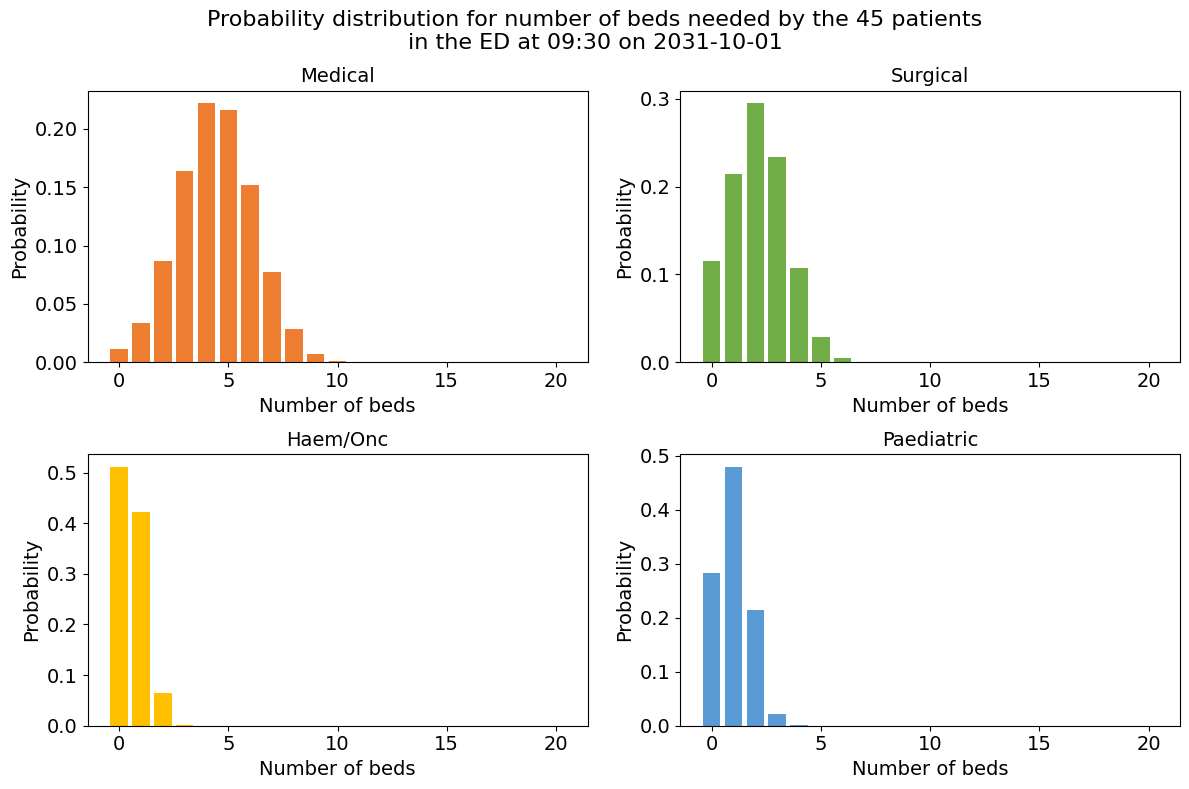

In [38]:
import matplotlib.pyplot as plt
from patientflow.viz.probability_distribution import plot_prob_dist
from patientflow.viz.pipeline_plots import create_colour_dict
from patientflow.aggregate import get_prob_dist
from patientflow.viz.utils import format_prediction_time

spec_colour_dict = create_colour_dict()
plot_order = ["medical", "surgical", "haem/onc", "paediatric"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, specialty in zip(axes.flat, plot_order):

    prob_admission_to_specialty = prediction_snapshots['consultation_sequence'].apply(spec_model.predict).apply(lambda x, s=specialty: x[s])

    prob_dist_dict = get_prob_dist(
            group_snapshots_dict, X_test, y_test, admission_model, 
            weights=prob_admission_to_specialty
        )

    title = specialty.title()
    plot_prob_dist(prob_dist_dict[first_group_snapshot_key]['agg_predicted'], title, 
        include_titles=True,
        truncate_at_beds=20,
        bar_colour=spec_colour_dict["single"].get(specialty, "#5B9BD5"),
        ax=ax,
        text_size=14,
    )

fig.suptitle(
    f'Probability distribution for number of beds needed by the '
    f'{len(prediction_snapshots)} patients\n'
    f'in the ED at {format_prediction_time((9,30))} '
    f'on {first_group_snapshot_key}',
    fontsize=16,
)
fig.tight_layout()
plt.show()

To compare these with the predictions overall (not by specialty) uses the same function without weighting the probability for each specialty. 

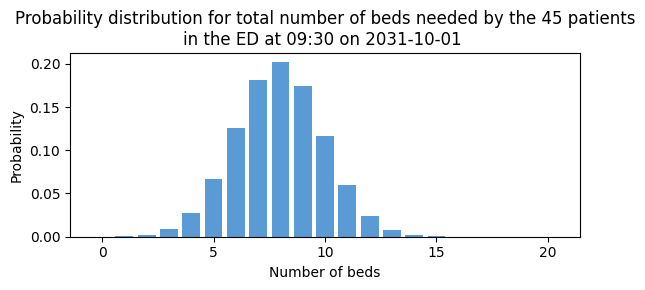

In [39]:
# get probability distribution for this time of day
prob_dist_dict = get_prob_dist(
        group_snapshots_dict, X_test, y_test, admission_model 
        # commenting out the weights argument
        # weights=prob_admission_to_specialty
    )

title = (
    f'Probability distribution for total number of beds needed by the '
    f'{len(prediction_snapshots)} patients\n'
    f'in the ED at {format_prediction_time((9,30))} '
    f'on {first_group_snapshot_key} '
)
plot_prob_dist(prob_dist_dict[first_group_snapshot_key]['agg_predicted'], title, 
    include_titles=True, truncate_at_beds=20)

## Stratifying by observed characteristics

Disaggregation of predictions using unchanging attributes like sex is very straightforward. Here I show breakdowns by sex. 

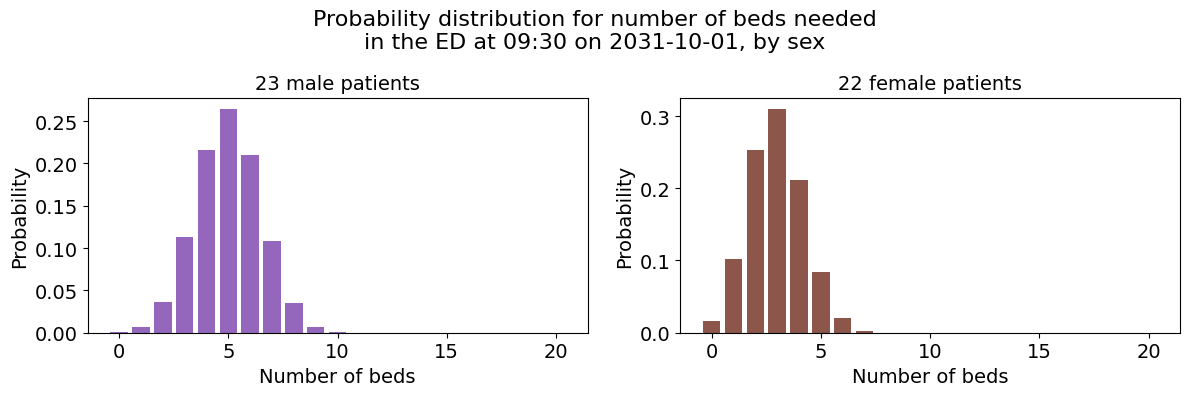

In [42]:
sex_colour_dict = {"M": "#9467BD", "F": "#8C564B"}
sex_labels = {"M": "male", "F": "female"}

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, sex in zip(axes.flat, ['M', 'F']):

    prediction_snapshots = test_visits[(test_visits.snapshot_date == first_group_snapshot_key) & 
                                       (test_visits.sex == sex) &
                                       (test_visits.prediction_time == (9,30))]
    
    group_snapshots_dict = prepare_group_snapshot_dict(
        prediction_snapshots
    )

    prob_dist_dict = get_prob_dist(
            group_snapshots_dict, X_test, y_test, admission_model
        )

    title = f'{len(prediction_snapshots)} {sex_labels[sex]} patients'
    plot_prob_dist(prob_dist_dict[first_group_snapshot_key]['agg_predicted'], title, 
        include_titles=True,
        truncate_at_beds=20,
        bar_colour=sex_colour_dict[sex],
        ax=ax,
        text_size=14,
    )

fig.suptitle(
    f'Probability distribution for number of beds needed\n'
    f'in the ED at {format_prediction_time((9,30))} '
    f'on {first_group_snapshot_key}, by sex',
    fontsize=16,
)
fig.tight_layout()
plt.show()

## Summary

In this notebook I have shown how to predict bed demand by hospital service, using both sequence-based and simpler input data to predict which service a patient will be admitted to. I also demonstrated stratification by observed patient characteristics such as sex.

In the next notebook, I evaluate these predictions across the full test set and compare them against a baseline.